# Bungee Jumping Drop

Shreya Chowdhary & Gail Romer


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

We used google to find the average weight for a human, approximated the diameter of a spherical human by curling in balls and measuring ourselves, found k value for bungee cord from https://bungeejournal.academic.wlu.edu/files/2014/11/Does-a-Bungee-Cord-Behave-Like-an-Ideal-Spring.pdf

drag coefficient of a sphere: https://en.wikipedia.org/wiki/Drag_coefficient

mass bungee taken from the jump notebook (?)

In [3]:
params = Params(init_height = 220 * m,
                g = 9.8 * m/s**2,
                mass_human = 62 * kg,
#                 mass_object = 10 * kg,
                mass_object = 0 * kg,
                diameter = 0.8128 * m, # diameter of a spherical human
                rho = 1.2 * kg/m**3,   # rho of air for drag calculations
                k = 40 * N/m,      # k value for an average bungee cord
                bungee_rest_length = 100 * m, # bungee cord less than half of init_height FOR NOW
                t_0 = 0 *s,
                t_end = 2000 * s,
                dt = 0.1*s,
#                dt = .01*s, # will use for final essay
               C_d = 0.47,
               mass_bungee = 75 * kg)

,values
init_height,220 meter
g,9.8 meter / second ** 2
mass_human,62 kilogram
mass_object,0 kilogram
diameter,0.8128 meter
rho,1.2 kilogram / meter ** 3
k,40.0 newton / meter
bungee_rest_length,100 meter
t_0,0 second
t_end,2000 second


In [4]:
def make_system(params):
    init = State(h = params.init_height, 
                 v = 0 * m/s)
    area = np.pi * (params.diameter/2)**2
    mu = params.mass_bungee/(params.mass_human + params.mass_object)
    system = System(params, init = init, area = area, mu = mu)
    return system

In [5]:
def drag_force(v, system):
    unpack(system)
    return -np.sign(v) * -rho * v**2 * C_d * area / 2
#     return 0 

In [6]:
def whip_force(system, state):
    unpack(system)
    h, v = state
    a = np.sign(v)*(mu * (v**2)/2)/(mu*(bungee_rest_length + h) + 2*bungee_rest_length)
#     return total_mass*a
    return 0

In [7]:
def spring_force(h, system):
    unpack(system)
    return k*((init_height - h) - bungee_rest_length)

In [8]:
def free_fall_event(state, t, system):
    unpack(system)
    h, v = state
    
    return bungee_rest_length - (init_height - h)

In [94]:
def slope_stage_14(state, t, system): #Stages 1 & 4 involve the same forces
    unpack(system)
    h, v = state
    
    f_drag = drag_force(v, system)
    f_whip = whip_force(system, state)
    f_grav = (total_mass)*(-g)
    
#     print(v, f_drag)
#     print(h, f_whip)
    
    net_force = f_drag + f_whip + f_grav
    a = net_force/total_mass
    print("net force: ", net_force)
    print("a: ", a)
    print("f_drag: ", f_drag)
    print("f_whip: ", f_whip)
    print("f_grav: ", f_grav)
    dhdt = v
    dvdt = a 
    
    return dhdt, dvdt

In [95]:
def slope_stage_23(state, t, system):
    unpack(system)
    h, v = state
    f_drag = drag_force(v, system)
    f_spring = spring_force(h, system)
    f_grav = (total_mass)*(-g)
    
#     print(v, f_drag)
#     print(h, f_spring)
    
    net_force = f_drag + f_spring + f_grav
    a = net_force/total_mass
    dhdt = v
    dvdt = a
    
    return dhdt, dvdt

### Stage 1: Freefall

In [96]:
def plot_height(heights, stage):
    plot(heights)
    title = "Height v.s. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Height (m)")

In [97]:
def plot_velocity(velocities, stage):
    plot(velocities)
    title = "Velocity v.s. Time for " + stage
    decorate(title = title, xlabel="Time (s)", ylabel="Velocity (m/s)")

In [98]:
def free_fall(sys):
    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    free_fall_results, details = run_ode_solver(system, slope_stage_14, events = free_fall_event, max_step = dt)
    
    h_final = get_last_value(free_fall_results.h) * m
    plot_height(free_fall_results.h, "Free Fall Stage")
    v_final = get_last_value(free_fall_results.v) * m/s
    plt.figure()
    plot_velocity(free_fall_results.v, "Free Fall Stage")
    free_fall_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(free_fall_results) * s
    
    system = System(system, init = free_fall_state, t_0 = t_final)
    
    return system, free_fall_results

### Stage 2: Stretch

In [99]:
def stretch_event(state, t, system):
    unpack(system)
    h, v = state
    return v

In [100]:
def stretch(sys):
    unpack(sys)
    stretch_results, details = run_ode_solver(sys, slope_stage_23, events = stretch_event, max_step = dt)
#     print(stretch_results.h)
    
    h_final = get_last_value(stretch_results.h) * m
    plot_height(stretch_results.h, "Stretch Stage")
    v_final = get_last_value(stretch_results.v) * m/s
    plt.figure()
    plot_velocity(stretch_results.v, "Stretch Stage")
    stretch_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(stretch_results) * s
    
    system = System(sys, init = stretch_state, t_0 = t_final)
    
    return system, stretch_results
        
# final_V_of_freefall = 20 * m/s
# final_height_of_freefall = 100 * m
# t = 20 * s

# delta_Y = 220 * m - final_height_of_freefall


# F_g = -(params.mass_human+params.mass_object)*params.g
# F_bungee = -params.k*(delta_Y - params.bungee_rest_length) # NEED TO MAKE THIS A FUNC OF DT
# # F_drag
# a = -(F_bungee - F_g)/(params.mass_human+params.mass_object)
# v = final_V_of_freefall + a*dt
# height = final_height_of_freefall + v*dt


# # EPE_of_Bungee = (1/2)*params.k*delta_Y

# #End characteristic of Stage 2 => (v = 0)
# # return Final Height of Stretch Stage, final V of stretch stage, final t of stretch stage, EPE of Bungee

### Stage 3: Release
is this a necessary stage?

In [101]:
def return_event(state, t, system):
    unpack(system)
    h, v = state
    
    return (init_height - h) - bungee_rest_length

In [102]:
def bungee_return(sys):
    unpack(sys)
    sys = System(sys,total_mass = mass_human)
    return_results, details = run_ode_solver(sys, slope_stage_23, events = return_event, max_step = dt)
#     print(return_results.h)

    h_final = get_last_value(return_results.h) * m
    plot_height(return_results.h, "Return Stage")
    v_final = get_last_value(return_results.v) * m/s
    plt.figure()
    plot_velocity(return_results.v, "Return Stage")
    return_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(return_results) * s
    
    system = System(sys, init = return_state, t_0 = t_final)
    
    return system, return_results

In [103]:
# final_V_of_stretch = 0 * m/s
# final_height_of_stretch = 10 * m
# t = 40 * s
# EPE_of_Bungee =  (1/2)*params.k*delta_Y

# delta_Y = 220 * m - final_height_of_freefall

# F_g = -(params.mass_human+params.mass_object)*params.g
# F_bungee = -params.k*(delta_Y - params.bungee_rest_length)
# a = -(F_bungee - F_g)/(params.mass_human+params.mass_object)
# v = final_V_of_freefall + a*dt
# height = final_height_of_freefall + v*dt

# #End characteristic of Stage 2 => (v = 0)
# # return Final Height of Stretch Stage, final V of stretch stage, final t of stretch stage

### Stage 4: Return (pull)

### Stage 5: Freefly

In [104]:
def free_fly_event(state,t,system):
    unpack(system)
    h, v = state
    return v

In [105]:
def free_fly(sys):
    unpack(sys)
    system = System(sys, total_mass = sys.mass_human + sys.mass_object)
    free_fly_results, details = run_ode_solver(system, slope_stage_14, events = free_fly_event, max_step = dt)
    
    h_final = get_last_value(free_fly_results.h) * m
    plot_height(free_fly_results.h, "Free Fly Stage")
    v_final = get_last_value(free_fly_results.v) * m/s
    plt.figure()
    plot_velocity(free_fly_results.v, "Free Fly Stage")
    free_fly_state = State(h = h_final, v = v_final)
    
    t_final = get_last_label(free_fly_results) * s
    
    system = System(system, init = free_fly_state, t_0 = t_final)
    
    return system, free_fly_results

### End Stage: Pass Height 0

net force:  -607.6 kilogram / meter
a:  -9.8 1 / meter
f_drag:  0.0 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -607.6000000000147 kilogram / meter
a:  -9.800000000000237 1 / meter
f_drag:  -1.4631957514304726e-11 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -607.6000000058528 kilogram / meter
a:  -9.800000000094402 1 / meter
f_drag:  -5.852783005721892e-09 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -607.6000000131688 kilogram / meter
a:  -9.8000000002124 1 / meter
f_drag:  -1.316876176306453e-08 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -607.6000000936446 kilogram / meter
a:  -9.800000001510396 1 / meter
f_drag:  -9.364452810117182e-08 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -607.6000001156106 kilogram / meter
a:  -9.800000001864687 1 / meter
f_drag:  -1.1561052852275

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -610.3452639038485 kilogram / meter
a:  -9.844278450062072 1 / meter
f_drag:  -2.745263903848455 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -611.0050031808937 kilogram / meter
a:  -9.854919406143447 1 / meter
f_drag:  -3.4050031808937367 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -611.1298033616868 kilogram / meter
a:  -9.85693231228527 1 / meter
f_drag:  -3.529803361686694 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -611.2889984517427 kilogram / meter
a:  -9.859499975028108 1 / meter
f_drag:  -3.688998451742719 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -611.2889973841164 kilogram / meter
a:  -9.85949995780833 1 / meter
f_drag:  -3.688997384116397 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -611.5844361100636 kil

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -639.9577607792138 kilogram / meter
a:  -10.321899367406674 1 / meter
f_drag:  -32.3577607792138 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -640.3584305778077 kilogram / meter
a:  -10.328361783513026 1 / meter
f_drag:  -32.75843057780765 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -640.8630504402496 kilogram / meter
a:  -10.336500813552412 1 / meter
f_drag:  -33.263050440249536 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -640.8630083398562 kilogram / meter
a:  -10.336500134513809 1 / meter
f_drag:  -33.26300833985609 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -641.7814142105508 kilogram / meter
a:  -10.351313132428238 1 / meter
f_drag:  -34.18141421055076 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -642.24680800964

net force:  -717.2384462699703 kilogram / meter
a:  -11.568362036612424 1 / meter
f_drag:  -109.63844626997023 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -721.9364174967749 kilogram / meter
a:  -11.644135766077014 1 / meter
f_drag:  -114.33641749677484 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -722.7854247879861 kilogram / meter
a:  -11.657829432064293 1 / meter
f_drag:  -115.18542478798616 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -723.8521878705916 kilogram / meter
a:  -11.675035288235348 1 / meter
f_drag:  -116.25218787059153 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -723.8518596814802 kilogram / meter
a:  -11.675029994862584 1 / meter
f_drag:  -116.25185968148013 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -725.7859033598232 kilogram / meter
a:  -11.70622424773908

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -818.4081727470705 kilogram / meter
a:  -13.200131818501136 1 / meter
f_drag:  -210.8081727470705 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -820.0420284179806 kilogram / meter
a:  -13.226484329322268 1 / meter
f_drag:  -212.44202841798057 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -820.0411018597687 kilogram / meter
a:  -13.226469384834978 1 / meter
f_drag:  -212.44110185976868 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -823.0010308422651 kilogram / meter
a:  -13.274210174875243 1 / meter
f_drag:  -215.40103084226504 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -824.5007771562288 kilogram / meter
a:  -13.298399631552076 1 / meter
f_drag:  -216.90077715622874 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -832.0925340

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -967.0794735660993 kilogram / meter
a:  -15.598056025259666 1 / meter
f_drag:  -359.4794735660993 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -971.6187355881798 kilogram / meter
a:  -15.671269928841609 1 / meter
f_drag:  -364.0187355881797 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -973.9231669227736 kilogram / meter
a:  -15.708438176173768 1 / meter
f_drag:  -366.32316692277357 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -985.5845825630288 kilogram / meter
a:  -15.896525525210143 1 / meter
f_drag:  -377.98458256302877 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -987.6934247912934 kilogram / meter
a:  -15.93053910953699 1 / meter
f_drag:  -380.09342479129344 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  -990.341398979

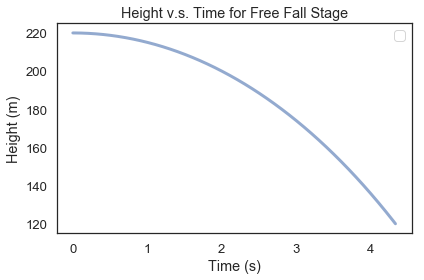

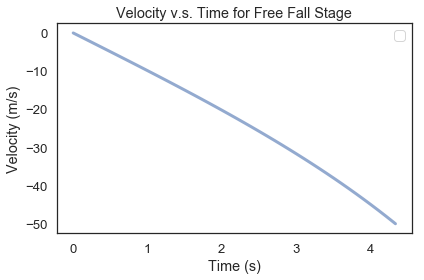

In [106]:
system = make_system(params)
free_fall_system, free_fall_results= free_fall(system)

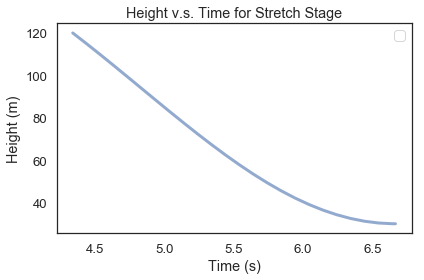

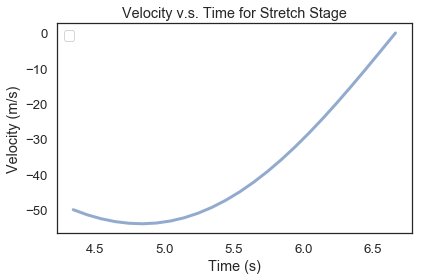

In [107]:
stretch_system, stretch_results = stretch(free_fall_system)

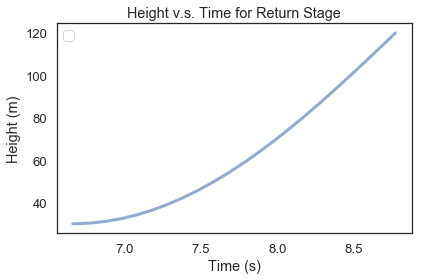

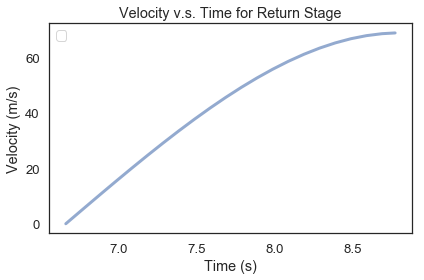

In [108]:
return_system, return_results = bungee_return(stretch_system)

net force:  85.61154202224964 kilogram / meter
a:  1.3808313229395102 1 / meter
f_drag:  693.2115420222497 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  86.2970519769649 kilogram / meter
a:  1.391887935112337 1 / meter
f_drag:  693.8970519769649 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  86.16792498205598 kilogram / meter
a:  1.3898052416460642 1 / meter
f_drag:  693.767924982056 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  86.45026967384194 kilogram / meter
a:  1.3943591882877733 1 / meter
f_drag:  694.050269673842 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  87.867861584705 kilogram / meter
a:  1.4172235739468548 1 / meter
f_drag:  695.467861584705 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  88.12286942399214 kilogram / meter
a:  1.4213366036127766 1 / meter
f_drag:  695.7228

net force:  112.38532907134595 kilogram / meter
a:  1.8126665979249348 1 / meter
f_drag:  719.985329071346 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  114.26287508162727 kilogram / meter
a:  1.8429495980907624 1 / meter
f_drag:  721.8628750816273 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  114.60075965816225 kilogram / meter
a:  1.8483993493251976 1 / meter
f_drag:  722.2007596581623 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  115.02377249785661 kilogram / meter
a:  1.8552221370622035 1 / meter
f_drag:  722.6237724978566 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  115.02291609749045 kilogram / meter
a:  1.855208324153072 1 / meter
f_drag:  722.6229160974905 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  115.78618288540827 kilogram / meter
a:  1.8675190787969076 1 / meter
f_drag

net force:  150.44077333072926 kilogram / meter
a:  2.426464085979504 1 / meter
f_drag:  758.0407733307293 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  150.43957315638693 kilogram / meter
a:  2.4264447283288213 1 / meter
f_drag:  758.039573156387 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  151.4621027963301 kilogram / meter
a:  2.4429371418762917 1 / meter
f_drag:  759.0621027963301 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  151.98145019002027 kilogram / meter
a:  2.4513137127422624 1 / meter
f_drag:  759.5814501900203 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  154.59053864393536 kilogram / meter
a:  2.4933957845796026 1 / meter
f_drag:  762.1905386439354 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  155.0603538980481 kilogram / meter
a:  2.5009734499685177 1 / meter
f_drag: 

net force:  243.53363203343997 kilogram / meter
a:  3.927961806990967 1 / meter
f_drag:  851.13363203344 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  244.3160420280392 kilogram / meter
a:  3.94058132303289 1 / meter
f_drag:  851.9160420280392 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  245.2957664488539 kilogram / meter
a:  3.9563833298202242 1 / meter
f_drag:  852.8957664488539 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  245.2934469005221 kilogram / meter
a:  3.9563459177503564 1 / meter
f_drag:  852.8934469005221 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  247.0622513453718 kilogram / meter
a:  3.9848750216995454 1 / meter
f_drag:  854.6622513453718 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  247.96170473733252 kilogram / meter
a:  3.9993823344731054 1 / meter
f_drag:  855.

f_drag:  948.3105245528741 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  342.15228208607834 kilogram / meter
a:  5.5185851949367475 1 / meter
f_drag:  949.7522820860784 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  342.1485045182767 kilogram / meter
a:  5.518524266423817 1 / meter
f_drag:  949.7485045182767 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  344.75248559553177 kilogram / meter
a:  5.560523961218254 1 / meter
f_drag:  952.3524855955318 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  346.0781389195247 kilogram / meter
a:  5.5819054664439465 1 / meter
f_drag:  953.6781389195247 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  352.7483458882996 kilogram / meter
a:  5.689489449811283 1 / meter
f_drag:  960.3483458882996 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / s

a:  7.550341935469024 1 / meter
f_drag:  1075.7211999990795 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  471.91358070881995 kilogram / meter
a:  7.61150936627129 1 / meter
f_drag:  1079.51358070882 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  473.8468981115915 kilogram / meter
a:  7.642691905025669 1 / meter
f_drag:  1081.4468981115915 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  483.58345511756704 kilogram / meter
a:  7.799733147057533 1 / meter
f_drag:  1091.183455117567 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  485.3442739004596 kilogram / meter
a:  7.828133450007413 1 / meter
f_drag:  1092.9442739004596 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  487.5496689603507 kilogram / meter
a:  7.863704338070172 1 / meter
f_drag:  1095.1496689603507 kilogram / meter
f_whip:  0
f_gr

a:  10.71137751398377 1 / meter
f_drag:  1271.7054058669937 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  678.9263262224173 kilogram / meter
a:  10.9504246164906 1 / meter
f_drag:  1286.5263262224173 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  681.6125747622144 kilogram / meter
a:  10.993751205842168 1 / meter
f_drag:  1289.2125747622144 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  684.9774225129355 kilogram / meter
a:  11.048022943757024 1 / meter
f_drag:  1292.5774225129355 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  684.9656483069931 kilogram / meter
a:  11.047833037209566 1 / meter
f_drag:  1292.5656483069931 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  691.0501747056625 kilogram / meter
a:  11.145970559768749 1 / meter
f_drag:  1298.6501747056625 kilogram / meter
f_whip:  0

a:  15.968021410556931 1 / meter
f_drag:  1597.6173274545297 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  995.4600874784452 kilogram / meter
a:  16.055807862555568 1 / meter
f_drag:  1603.0600874784452 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  995.4368038499571 kilogram / meter
a:  16.055432320160598 1 / meter
f_drag:  1603.036803849957 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1005.2876286639622 kilogram / meter
a:  16.21431659135423 1 / meter
f_drag:  1612.8876286639622 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1010.3343633528985 kilogram / meter
a:  16.295715537949977 1 / meter
f_drag:  1617.9343633528986 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1035.8310525927895 kilogram / meter
a:  16.706952461174026 1 / meter
f_drag:  1643.4310525927897 kilogram / meter
f_whip

a:  24.51301654965208 1 / meter
f_drag:  2127.4070260784288 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1537.1417621105084 kilogram / meter
a:  24.79260906629852 1 / meter
f_drag:  2144.7417621105083 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1546.0588478610352 kilogram / meter
a:  24.936433030016698 1 / meter
f_drag:  2153.658847861035 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1591.2238713850684 kilogram / meter
a:  25.66490115137207 1 / meter
f_drag:  2198.8238713850683 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1599.4803227471843 kilogram / meter
a:  25.79806972172878 1 / meter
f_drag:  2207.0803227471843 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1609.822445848547 kilogram / meter
a:  25.964878158847533 1 / meter
f_drag:  2217.422445848547 kilogram / meter
f_whip:  

net force:  2555.6513548448984 kilogram / meter
a:  41.22018314265965 1 / meter
f_drag:  3163.2513548448983 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2646.6050051116276 kilogram / meter
a:  42.68717750180045 1 / meter
f_drag:  3254.2050051116275 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2663.365108718829 kilogram / meter
a:  42.9575017535295 1 / meter
f_drag:  3270.965108718829 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2684.3480371786227 kilogram / meter
a:  43.29593608352617 1 / meter
f_drag:  3291.9480371786226 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2684.173939634558 kilogram / meter
a:  43.2931280586219 1 / meter
f_drag:  3291.773939634558 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2722.2892001300334 kilogram / meter
a:  43.90789032467796 1 / meter
f_drag:  33

net force:  5075.370370443059 kilogram / meter
a:  81.86081242650096 1 / meter
f_drag:  5682.970370443059 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5128.146751849026 kilogram / meter
a:  82.71204438466171 1 / meter
f_drag:  5735.746751849027 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5127.426197672486 kilogram / meter
a:  82.70042254310461 1 / meter
f_drag:  5735.026197672486 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5223.653653186315 kilogram / meter
a:  84.25247827719862 1 / meter
f_drag:  5831.253653186315 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5274.116345152999 kilogram / meter
a:  85.06639266375805 1 / meter
f_drag:  5881.716345153 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5532.824193949008 kilogram / meter
a:  89.23909990240335 1 / meter
f_drag:  6140.42419

net force:  12808.473659195848 kilogram / meter
a:  206.5882848257395 1 / meter
f_drag:  13416.073659195848 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  13177.098432307688 kilogram / meter
a:  212.53384568238206 1 / meter
f_drag:  13784.698432307689 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  13375.383673472425 kilogram / meter
a:  215.7319947334262 1 / meter
f_drag:  13982.983673472425 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  14409.488843251374 kilogram / meter
a:  232.41111037502216 1 / meter
f_drag:  15017.088843251375 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  14610.916992552831 kilogram / meter
a:  235.6599514927876 1 / meter
f_drag:  15218.516992552832 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  14860.188150828573 kilogram / meter
a:  239.68045404562216 1 / meter
f_

net force:  74983.81160124435 kilogram / meter
a:  1209.4163161491024 1 / meter
f_drag:  75591.41160124436 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  89709.82516002115 kilogram / meter
a:  1446.932663871309 1 / meter
f_drag:  90317.42516002116 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  93082.69782621217 kilogram / meter
a:  1501.333835906648 1 / meter
f_drag:  93690.29782621218 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  97020.61253307748 kilogram / meter
a:  1564.8485892431852 1 / meter
f_drag:  97628.21253307749 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  96556.54230331494 kilogram / meter
a:  1557.3635855373377 1 / meter
f_drag:  97164.14230331495 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  104126.22759236542 kilogram / meter
a:  1679.4552837478293 1 / meter
f_drag:  10

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  11493377.944204709 kilogram / meter
a:  185377.06361620498 1 / meter
f_drag:  11493985.544204708 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  12789278.565363782 kilogram / meter
a:  206278.6865381255 1 / meter
f_drag:  12789886.165363781 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  12547184.469575556 kilogram / meter
a:  202373.94305767026 1 / meter
f_drag:  12547792.069575556 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  17314622.61507607 kilogram / meter
a:  279268.1066947753 1 / meter
f_drag:  17315230.21507607 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  22420876.057116862 kilogram / meter
a:  361627.0331793042 1 / meter
f_drag:  22421483.657116864 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  105805956.26100357 kilogra

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  565477168.3687143 kilogram / meter
a:  9120599.489817973 1 / meter
f_drag:  565477775.9687144 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  786988112.5134102 kilogram / meter
a:  12693356.6534421 1 / meter
f_drag:  786988720.1134102 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1028702098.5671833 kilogram / meter
a:  16591969.331728762 1 / meter
f_drag:  1028702706.1671833 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5164021724.991951 kilogram / meter
a:  83290672.98374115 1 / meter
f_drag:  5164022332.591951 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4505097351.950417 kilogram / meter
a:  72662860.5153293 1 / meter
f_drag:  4505097959.550417 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  14080028727.273874 kilogram / meter

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  45398959232.52015 kilogram / meter
a:  732241277.9438734 1 / meter
f_drag:  45398959840.12015 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  229896933973.05438 kilogram / meter
a:  3708015064.0815225 1 / meter
f_drag:  229896934580.6544 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  198791061322.369 kilogram / meter
a:  3206307440.6833706 1 / meter
f_drag:  198791061929.969 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  634220440181.4784 kilogram / meter
a:  10229361938.410942 1 / meter
f_drag:  634220440789.0784 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1566383443534.5193 kilogram / meter
a:  25264249089.26644 1 / meter
f_drag:  1566383444142.1194 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  28787179276.456875 kilogram / me

f_grav:  -607.6 kilogram * meter / second ** 2
net force:  8723217983738.959 kilogram / meter
a:  140697064253.8542 1 / meter
f_drag:  8723217984346.559 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  27917530453214.086 kilogram / meter
a:  450282749245.3885 1 / meter
f_drag:  27917530453821.688 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  69113690198219.34 kilogram / meter
a:  1114736938680.9573 1 / meter
f_drag:  69113690198826.945 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1262668847805.764 kilogram / meter
a:  20365626577.51232 1 / meter
f_drag:  1262668848413.364 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1385058735179.7278 kilogram / meter
a:  22339657019.027866 1 / meter
f_drag:  1385058735787.328 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2267223432606.4004 kilogram / 

f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  3033164462238424.5 kilogram / meter
a:  48922007455458.46 1 / meter
f_drag:  3033164462239032.0 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  55347082314104.75 kilogram / meter
a:  892694876033.9476 1 / meter
f_drag:  55347082314712.35 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  60710981398372.03 kilogram / meter
a:  979209377393.0973 1 / meter
f_drag:  60710981398979.63 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  99370429075264.17 kilogram / meter
a:  1602748856052.648 1 / meter
f_drag:  99370429075871.77 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  111619853583446.48 kilogram / meter
a:  1800320219087.8464 1 / meter
f_drag:  111619853584054.08 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  125476844760280.11 k

f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2660471782652274.0 kilogram / meter
a:  42910835204068.94 1 / meter
f_drag:  2660471782652881.5 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4354478441129365.0 kilogram / meter
a:  70233523244022.016 1 / meter
f_drag:  4354478441129972.5 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4891223934701965.0 kilogram / meter
a:  78890708624225.23 1 / meter
f_drag:  4891223934702573.0 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5498401885046657.0 kilogram / meter
a:  88683901371720.28 1 / meter
f_drag:  5498401885047265.0 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5396746707023537.0 kilogram / meter
a:  87044301726186.08 1 / meter
f_drag:  5396746707024145.0 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  75214713041224

f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.1430676497111882e+17 kilogram / meter
a:  3456560725340626.0 1 / meter
f_drag:  2.1430676497111942e+17 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.4090898933328624e+17 kilogram / meter
a:  3885628860214294.0 1 / meter
f_drag:  2.4090898933328685e+17 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.3645493435000522e+17 kilogram / meter
a:  3813789263709761.5 1 / meter
f_drag:  2.3645493435000582e+17 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  3.2955058914689766e+17 kilogram / meter
a:  5315332083014478.0 1 / meter
f_drag:  3.2955058914689824e+17 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4.314556157300637e+17 kilogram / meter
a:  6958961544033285.0 1 / meter
f_drag:  4.3145561573006426e+17 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * met

f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.0359138410231562e+19 kilogram / meter
a:  1.6708287758438003e+17 1 / meter
f_drag:  1.0359138410231562e+19 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.4437751408928842e+19 kilogram / meter
a:  2.328669582085297e+17 1 / meter
f_drag:  1.4437751408928842e+19 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.890236155144563e+19 kilogram / meter
a:  3.04876799216865e+17 1 / meter
f_drag:  1.890236155144563e+19 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  9.589133938016217e+19 kilogram / meter
a:  1.5466345061316477e+18 1 / meter
f_drag:  9.589133938016217e+19 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  8.276454429693614e+19 kilogram / meter
a:  1.3349120047892925e+18 1 / meter
f_drag:  8.276454429693614e+19 kilogram / meter
f_whip:  0
f_grav:  -607.6 ki

f_drag:  6.324794228764727e+20 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  8.280657282041374e+20 kilogram / meter
a:  1.3355898842002217e+19 1 / meter
f_drag:  8.280657282041374e+20 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4.200883432460832e+21 kilogram / meter
a:  6.775618439452955e+19 1 / meter
f_drag:  4.200883432460832e+21 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  3.625706792812578e+21 kilogram / meter
a:  5.847914181955771e+19 1 / meter
f_drag:  3.625706792812578e+21 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.1617568362475477e+22 kilogram / meter
a:  1.8738013487863674e+20 1 / meter
f_drag:  1.1617568362475477e+22 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.8787117886233243e+22 kilogram / meter
a:  4.6430835300376196e+20 1 / meter
f_drag:  2.8787117886233243e+

f_drag:  1.8402191607858826e+23 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.588233373797314e+23 kilogram / meter
a:  2.5616667319311516e+21 1 / meter
f_drag:  1.588233373797314e+23 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5.0892492592772167e+23 kilogram / meter
a:  8.208466547221317e+21 1 / meter
f_drag:  5.0892492592772167e+23 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.2610997478365613e+24 kilogram / meter
a:  2.0340318513492925e+22 1 / meter
f_drag:  1.2610997478365613e+24 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.2985508540910246e+22 kilogram / meter
a:  3.707340087243588e+20 1 / meter
f_drag:  2.2985508540910246e+22 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.521282220960865e+22 kilogram / meter
a:  4.066584227356234e+20 1 / meter
f_drag:  2.521282220960865

f_drag:  2.229195528670237e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5.52382286500037e+25 kilogram / meter
a:  8.909391717742533e+23 1 / meter
f_drag:  5.52382286500037e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.0068298580928727e+24 kilogram / meter
a:  1.6239191259562463e+22 1 / meter
f_drag:  1.0068298580928727e+24 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.1043953714349707e+24 kilogram / meter
a:  1.7812828571531785e+22 1 / meter
f_drag:  1.1043953714349707e+24 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.8075526522485542e+24 kilogram / meter
a:  2.9154075036267003e+22 1 / meter
f_drag:  1.8075526522485542e+24 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.030344727334901e+24 kilogram / meter
a:  3.2747495602175825e+22 1 / meter
f_drag:  2.030344727334901e

f_drag:  4.410797841350685e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4.838138794295641e+25 kilogram / meter
a:  7.803449668218775e+23 1 / meter
f_drag:  4.838138794295641e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  7.917753035197302e+25 kilogram / meter
a:  1.277056941160855e+24 1 / meter
f_drag:  7.917753035197302e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  8.893462130644008e+25 kilogram / meter
a:  1.434429375910324e+24 1 / meter
f_drag:  8.893462130644008e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  9.997142643037157e+25 kilogram / meter
a:  1.6124423617801866e+24 1 / meter
f_drag:  9.997142643037157e+25 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  9.81228296996942e+25 kilogram / meter
a:  1.5826262854789387e+24 1 / meter
f_drag:  9.81228296996942e+25 kilo

a:  5.59737720631727e+25 1 / meter
f_drag:  3.4703738679167077e+27 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  3.897970925590073e+27 kilogram / meter
a:  6.287049879983988e+25 1 / meter
f_drag:  3.897970925590073e+27 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4.3816360890282287e+27 kilogram / meter
a:  7.067154982303595e+25 1 / meter
f_drag:  4.3816360890282287e+27 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  4.300606981895763e+27 kilogram / meter
a:  6.9364628740254245e+25 1 / meter
f_drag:  4.300606981895763e+27 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  5.993658875710312e+27 kilogram / meter
a:  9.667191735016632e+25 1 / meter
f_drag:  5.993658875710312e+27 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  7.846812394836938e+27 kilogram / meter
a:  1.2656149023930546e+26 1 / m

a:  3.12046222192596e+27 1 / meter
f_drag:  1.9346865775940952e+29 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.899167239027627e+29 kilogram / meter
a:  3.063172966173592e+27 1 / meter
f_drag:  1.899167239027627e+29 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  2.651090814080153e+29 kilogram / meter
a:  4.2759529259357304e+27 1 / meter
f_drag:  2.651090814080153e+29 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  3.477025561915718e+29 kilogram / meter
a:  5.608105745025352e+27 1 / meter
f_drag:  3.477025561915718e+29 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.7844531814819372e+30 kilogram / meter
a:  2.878150292712802e+28 1 / meter
f_drag:  1.7844531814819372e+30 kilogram / meter
f_whip:  0
f_grav:  -607.6 kilogram * meter / second ** 2
net force:  1.5216256854373285e+30 kilogram / meter
a:  2.45423497651182e+28 1 / me

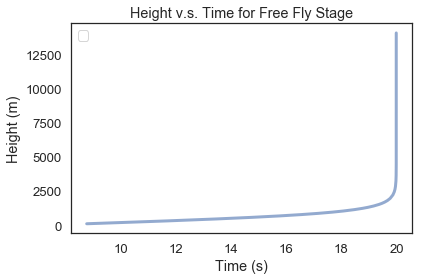

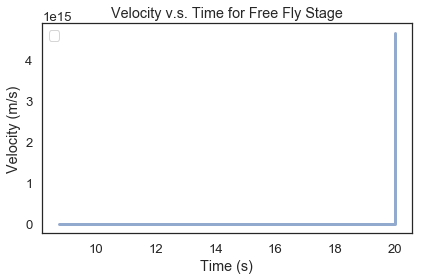

In [109]:
free_fly_system, free_fly_results= free_fly(return_system)
# free_fall_system2, free_fall_results2= free_fall(free_fly_system)
# stretch_system2, stretch_results2 = stretch(free_fall_system2)
# return_system2, return_results2 = bungee_return(stretch_system2)
# free_fly_system2, free_fly_results2= free_fly(return_system2)

14056.234847789712


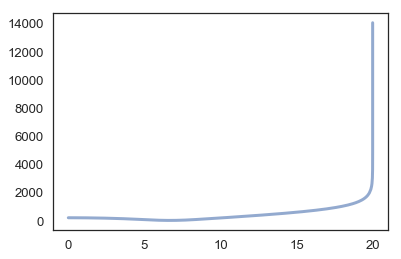

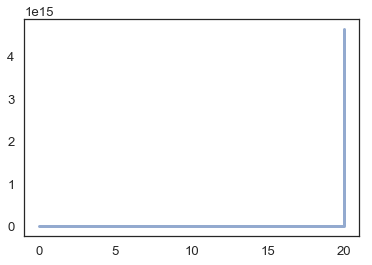

In [22]:
frames = [free_fall_results, stretch_results, return_results, free_fly_results,
          free_fall_results2, stretch_results2, return_results2, free_fly_results2]

result = pd.concat(frames)

plot(result.h)

plt.figure()
plot(result.v)

print(get_last_value(result.h))